In [16]:

from sklearn.preprocessing import MinMaxScaler
import pandas as pd
import numpy as np
import neurokit2 as nk
import scipy.signal as signal
import torch
import torch.nn as nn
import neurokit2 as nk
import tensorflow as tf
import scipy.signal as signal
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import os
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import torch.nn.functional as F
import time
from sklearn.metrics import classification_report, confusion_matrix
from torchsummary import summary

In [ ]:
# carga el documento que debe tener el formato indicado para funcionar
# luego normaliza con valores entre -1 y 1
# filtra las seniales que se consideran ruido

def cargar_y_filtrar(input_file, fs, lowcut=0.5, highcut=40.0, notch_freq=50.0, Q=30.0, order=4):
    df = pd.read_csv(input_file, sep=';', parse_dates=['Timestamp'])
    signal_raw = df['ECG_Value'].values.astype(np.float32)

    b, a = signal.butter(order, [lowcut / (0.5 * fs), highcut / (0.5 * fs)], btype='band')
    signal_filtered = signal.filtfilt(b, a, signal_raw)

    b_notch, a_notch = signal.iirnotch(notch_freq, Q, fs)
    
    signal_filtered = signal.filtfilt(b_notch, a_notch, signal_filtered)
    scaler = MinMaxScaler(feature_range=(0, 1))
    signal_normalizada = scaler.fit_transform(signal_filtered.reshape(-1, 1)).flatten()    
    
    joblib.dump(scaler, "minmaxscaler.pkl")
    
    return df, signal_normalizada

def detectar_r_peaks(signal_filtered, fs):
    signals, info = nk.ecg_process(signal_filtered, sampling_rate=fs)
    r_peaks = info["ECG_R_Peaks"]
    return r_peaks

def guardar_con_picos(df, signal_filtered, r_peaks, output_file):      
    df['Filtered_ECG'] = signal_filtered
    df['R_Peak'] = 0
    df.loc[r_peaks, 'R_Peak'] = 1
    df.to_csv(output_file, sep=';', index=False)
    print(f"Archivo con R Peaks guardado: {output_file}")
    
def segmentar_senal(signal_filtered, segment_length, output_segments_file):
    num_segments = len(signal_filtered) // segment_length
    signal_trimmed = signal_filtered[:num_segments * segment_length]
    signal_segments = signal_trimmed.reshape(num_segments, segment_length)
    np.savetxt(output_segments_file, signal_segments, delimiter=';', fmt='%.6f', header='', comments='')
    print(f"Archivo de segmentos guardado: {output_segments_file}")
    return signal_segments    

def cargar_y_guardar_imagenes_desde_csv(csv_path, carpeta_destino='imagenes'):
    df = pd.read_csv(csv_path, header=None)

    señales = df.iloc[:, :187].values.astype(np.float32)
    etiquetas = df.iloc[:, 187].astype(int).values

    os.makedirs(carpeta_destino, exist_ok=True)

    for i, (senal, etiqueta) in enumerate(zip(señales, etiquetas)):
        senal = senal.reshape(-1, 1)
        senal_norm = MinMaxScaler(feature_range=(0, 1)).fit_transform(senal).flatten()

        clase_path = os.path.join(carpeta_destino, str(etiqueta))
        os.makedirs(clase_path, exist_ok=True)

        plt.figure(figsize=(1.28, 1.28), dpi=100)
        plt.plot(senal_norm, color='black')
        plt.axis('off')
        plt.subplots_adjust(0, 0, 1, 1)
        nombre_archivo = os.path.join(clase_path, f'senal_{i:05d}.png')
        plt.savefig(nombre_archivo, bbox_inches='tight', pad_inches=0)
        plt.close()

    print(f"Imágenes generadas en: {os.path.abspath(carpeta_destino)}")

In [ ]:
from torch.utils.data import Subset

transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),  
    transforms.Resize((12, 12)),                   
    transforms.ToTensor(),
])


train_dataset = datasets.ImageFolder(root='imagenes_mitbih_train', transform=transform)
test_dataset = datasets.ImageFolder(root='imagenes_mitbih_test', transform=transform)


train_loader = DataLoader(
    train_dataset,
    batch_size=516,            
    shuffle=True,
    num_workers=6,           
    pin_memory=True           
)

test_loader = DataLoader(
    test_dataset,
    batch_size=516,           
    shuffle=False,
    num_workers=4,
    pin_memory=True
)
train_dataset = Subset(train_dataset, range(100))
test_dataset = Subset(test_dataset, range(50))

In [ ]:
input_file = 'mitbih_train.csv'
carpeta_imagenes = 'imagenes_mitbih_train'
fs = 125  
segment_length = 187  
# # se asigna la frecuencia en hz de las ondas como las de mitbih
# fs = 125
# # cantidad de segmentos segun la cantidad del dataset
# segment_length = 187

# # carga y filtrado de los datos para quitar ruido
# df, signal_filtered = cargar_y_filtrar(input_file, fs)

# # se detectan los r peaks de las seniales
# r_peaks = detectar_r_peaks(signal_filtered, fs)

# # se genera documento con peaks asignados
# # guardar_con_picos(df, signal_filtered, r_peaks, output_file)
# # --> los picos 
# # se genera documento final con segmentos de 187 filas
# signal_segments = segmentar_senal(signal_filtered, segment_length, output_segments_file)

#cargar_y_guardar_imagenes_desde_csv(input_file, carpeta_imagenes)

In [ ]:
class HeartNetTinyV2(nn.Module):
    def __init__(self, num_classes=5):
        super(HeartNetTinyV2, self).__init__()
        
        self.features = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1),  
            nn.ELU(inplace=True),
            nn.BatchNorm2d(16),
            nn.MaxPool2d(2), 

            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),
            nn.ELU(inplace=True),
            nn.BatchNorm2d(32),
            nn.MaxPool2d(2),  

            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ELU(inplace=True),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(2)  
        )

        self.dropout = nn.Dropout(0.5)

        self.classifier = nn.Sequential(
            nn.Linear(64 * 1 * 1, 128),  
            nn.ELU(inplace=True),
            nn.BatchNorm1d(128),
            nn.Dropout(0.5),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        x = self.features(x)        
        x = x.view(x.size(0), -1)
        x = self.dropout(x)
        x = self.classifier(x)
        return x



In [21]:
torch.backends.cudnn.benchmark = True

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = HeartNetTinyV2(num_classes=5).to(device)
summary(model, input_size=(1, 12, 12)) 

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 12, 12]             160
               ELU-2           [-1, 16, 12, 12]               0
       BatchNorm2d-3           [-1, 16, 12, 12]              32
         MaxPool2d-4             [-1, 16, 6, 6]               0
            Conv2d-5             [-1, 32, 6, 6]           4,640
               ELU-6             [-1, 32, 6, 6]               0
       BatchNorm2d-7             [-1, 32, 6, 6]              64
         MaxPool2d-8             [-1, 32, 3, 3]               0
            Conv2d-9             [-1, 64, 3, 3]          18,496
              ELU-10             [-1, 64, 3, 3]               0
      BatchNorm2d-11             [-1, 64, 3, 3]             128
        MaxPool2d-12             [-1, 64, 1, 1]               0
          Dropout-13                   [-1, 64]               0
           Linear-14                  [

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

epochs = 12
train_losses = []
val_losses = []

start_time_total = time.time()

for epoch in range(epochs):
    start_time_epoch = time.time()

    model.train()
    running_loss = 0.0
    for X_batch, y_batch in train_loader:       
        X_batch = X_batch.to(device, non_blocking=True)
        y_batch = y_batch.to(device, non_blocking=True)

        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    avg_train_loss = running_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    model.eval()
    val_running_loss = 0.0
    with torch.no_grad():
        for X_batch_val, y_batch_val in test_loader:
            X_batch_val = X_batch_val.to(device, non_blocking=True)
            y_batch_val = y_batch_val.to(device, non_blocking=True)
            outputs_val = model(X_batch_val)
            val_loss = criterion(outputs_val, y_batch_val)
            val_running_loss += val_loss.item()

    avg_val_loss = val_running_loss / len(test_loader)
    val_losses.append(avg_val_loss)

    end_time_epoch = time.time()
    epoch_duration = end_time_epoch - start_time_epoch

    print(f"Epoch {epoch+1:3}/{epochs} - "
          f"Train Loss: {avg_train_loss:.4f} - "
          f"Val Loss: {avg_val_loss:.4f} - "
          f"Duration: {epoch_duration:.2f}s")

end_time_total = time.time()
print(f"\nEntrenamiento completado en {end_time_total - start_time_total:.2f} segundos.")


Epoch   1/12 - Train Loss: 0.3024 - Val Loss: 0.1456 - Duration: 30.56s
Epoch   2/12 - Train Loss: 0.1528 - Val Loss: 0.1278 - Duration: 29.39s
Epoch   3/12 - Train Loss: 0.1308 - Val Loss: 0.1037 - Duration: 28.39s
Epoch   4/12 - Train Loss: 0.1208 - Val Loss: 0.1200 - Duration: 28.16s
Epoch   5/12 - Train Loss: 0.1101 - Val Loss: 0.1026 - Duration: 28.69s
Epoch   6/12 - Train Loss: 0.1165 - Val Loss: 0.0960 - Duration: 28.90s
Epoch   7/12 - Train Loss: 0.1016 - Val Loss: 0.0979 - Duration: 29.08s
Epoch   8/12 - Train Loss: 0.0961 - Val Loss: 0.0887 - Duration: 29.04s
Epoch   9/12 - Train Loss: 0.0944 - Val Loss: 0.0888 - Duration: 28.88s
Epoch  10/12 - Train Loss: 0.0907 - Val Loss: 0.1055 - Duration: 29.01s
Epoch  11/12 - Train Loss: 0.0861 - Val Loss: 0.0914 - Duration: 29.03s
Epoch  12/12 - Train Loss: 0.0833 - Val Loss: 0.0857 - Duration: 28.87s

Entrenamiento completado en 348.01 segundos.


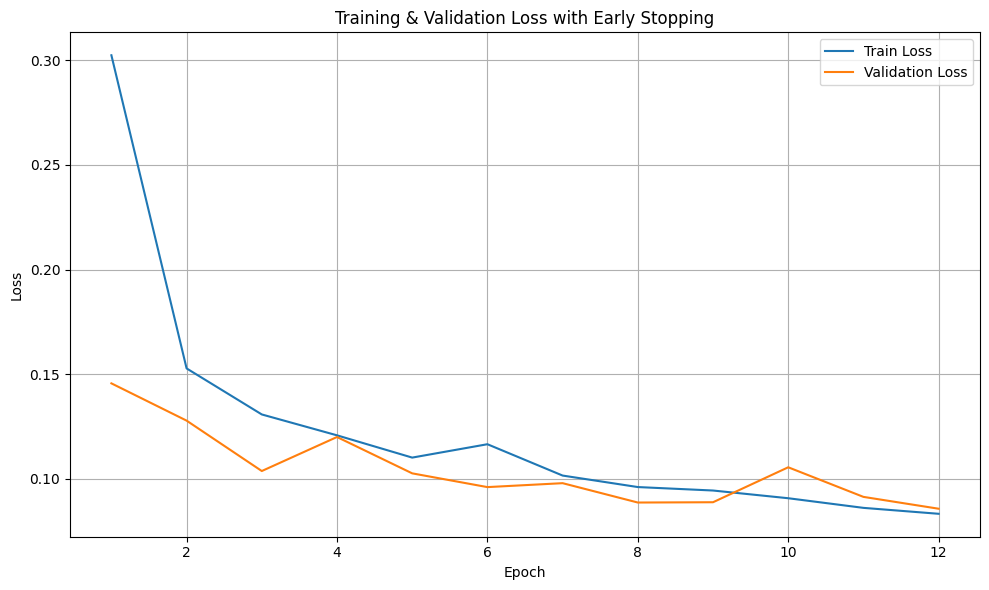

In [23]:
plt.figure(figsize=(10,6))
plt.plot(range(1, len(train_losses)+1), train_losses, label="Train Loss")
plt.plot(range(1, len(val_losses)+1), val_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training & Validation Loss with Early Stopping")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


Evaluando modelo...

Accuracy: 0.9778

Reporte de clasificación:

              precision    recall  f1-score   support

           0     0.9794    0.9969    0.9881     18118
           1     0.9355    0.6259    0.7500       556
           2     0.9749    0.9109    0.9418      1448
           3     0.8345    0.7160    0.7708       162
           4     0.9843    0.9720    0.9781      1608

    accuracy                         0.9778     21892
   macro avg     0.9417    0.8443    0.8857     21892
weighted avg     0.9773    0.9778    0.9766     21892



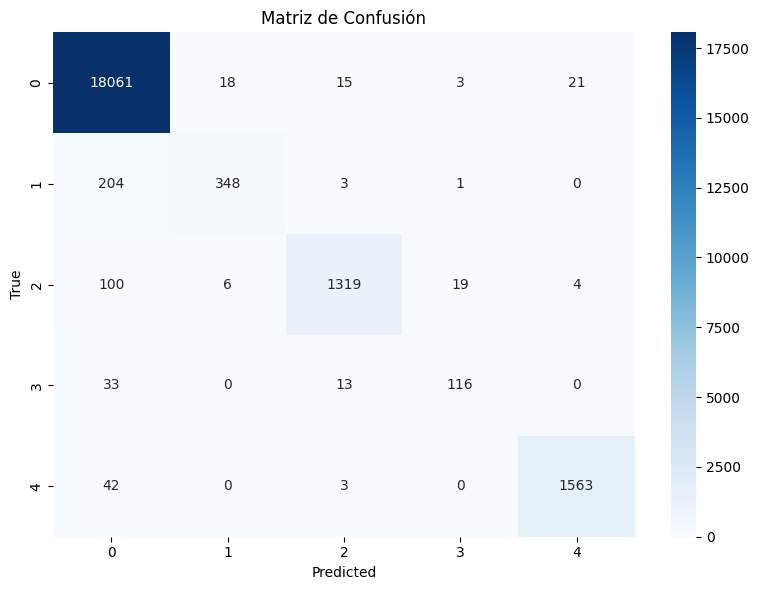


Tiempo de evaluación: 9.46 segundos
Tiempo total de ejecución: 357.72 segundos


In [ ]:
print("\nEvaluando modelo...")

model.eval()

y_true = []
y_pred = []

eval_start_time = time.time()

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        _, predicted = torch.max(outputs, dim=1)

        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())

eval_time = time.time() - eval_start_time

accuracy = np.mean(np.array(y_true) == np.array(y_pred))
print(f"\nAccuracy: {accuracy:.4f}")

print("\nReporte de clasificación:\n")
print(classification_report(y_true, y_pred, digits=4))

labels_unique = np.unique(np.concatenate((y_true, y_pred)))
conf_mat = confusion_matrix(y_true, y_pred, labels=labels_unique)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap="Blues",
            xticklabels=labels_unique, yticklabels=labels_unique)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Matriz de Confusión")
plt.tight_layout()
plt.show()

total_time = time.time() - start_time_total
print(f"\nTiempo de evaluación: {eval_time:.2f} segundos")
print(f"Tiempo total de ejecución: {total_time:.2f} segundos")
